# Spin Squeezing with collective and local incoherent processes

Notebook author: Nathan Shammah (nathan.shammah at gmail.com)

Here we study the effect of collective and local processes on a spin squeezing Hamiltonian. 

We consider a system of $N$ two-level systems (TLSs) with identical frequency $\omega_{0}$, which can de-excite incoherently or collectively at the rates $\gamma_\text{E}$ and $\gamma_\text{CE}$,

\begin{eqnarray}
\dot{\rho} &=&-i\lbrack -i\Lambda\left(J_{+}^2-J_{-}^2\right),\rho \rbrack
+\frac{\gamma_\text {CE}}{2}\mathcal{L}_{J_{-}}[\rho]
+\frac{\gamma_\text{E}}{2}\sum_{n=1}^{N}\mathcal{L}_{J_{-,n}}[\rho]
\end{eqnarray}

We study the time evolution of the spin squeezing parameter [1-4]
\begin{eqnarray}
\xi^2 &=& N\langle\Delta J_y^2\rangle/\left(\langle J_z\rangle^2+\langle J_x\rangle^2\right)
\end{eqnarray}

We assess how different dynamical conditions and initial states can be explored to optimize the spin squeezing of a given Dicke state [5-7]. We begin by comparting cases in which $\gamma_\text{E}$ or $\gamma_\text{CE}$ only are different from zero; further below we modulate the couplings $\gamma_\text{E}/\gamma_\text{CE}$, also as a function of $\Lambda$ and $N$, the number of TLSs.  

In [57]:
from time import clock
from scipy.io import mmwrite
import matplotlib.pyplot as plt
from qutip import *
from qutip.piqs import *
from scipy.sparse import load_npz, save_npz

In [58]:
def isdicke(N, j, m):
    """
    Check if an element in a matrix is a valid element in the Dicke space.
    Dicke row: j value index. Dicke column: m value index. 
    The function returns True if the element exists in the Dicke space and
    False otherwise.

    Parameters
    ----------
    N : int
        The number of two-level systems.    
    j: float
        "j" index of the element in Dicke space which needs to be checked.
    m: float
        "m" index of the element in Dicke space which needs to be checked.
    """
    dicke_row = j
    dicke_col = m
    
    rows = N + 1
    cols = 0

    if (N % 2) == 0:
        cols = int(N/2 + 1)
    else:
        cols = int(N/2 + 1/2)

    if (dicke_row > rows) or (dicke_row < 0):
        return (False)

    if (dicke_col > cols) or (dicke_col < 0):
        return (False)

    if (dicke_row < int(rows/2)) and (dicke_col > dicke_row):
        return False

    if (dicke_row >= int(rows/2)) and (rows - dicke_row <= dicke_col):
        return False

    else:
        return True

def dicke_space(N):
    """
    Generate a matrix to visualize the Dicke space.
    j is on the horizontal axis, increasing right to left.
    m is on the vertical axis, increasing bottom to top.
    It puts 1 in all allowed (j,m) values.
    It puts 0 in all not-allowed (j,m) values.
    Parameters
    ----------
    N : int
        The number of two-level systems.
    Returns
    ----------
    dicke_space : ndarray
        The matrix of all allowed (j,m) pairs.

    """        
    rows = N + 1
    cols = 0

    if (rows % 2) == 0:
        cols = int((rows/2))

    else:
        cols = int((rows + 1)/2)

    dicke_space = np.zeros((rows, cols), dtype = int)

    for (i, j) in np.ndindex(rows, cols):
        dicke_space[i, j] = isdicke(N, i, j)

    return (dicke_space)

In [59]:
## general parameters
N = 20
ntls = N
nds = num_dicke_states(N)
[jx, jy, jz] = jspin(N)
jp = jspin(N, "+")
jm = jspin(N, "-")
jpjm = jp*jm

Lambda = 1
factor_l = 5

#spin hamiltonian
h = -1j*Lambda * (jp**2-jm**2)
gCE = Lambda/factor_l
gE = Lambda/factor_l

# system with collective emission only
system = Dicke(N=N)
# system2 with local emission only
system2 = Dicke(N=N)
system.collective_emission = gCE
system2.emission = gE
system.hamiltonian = h
system2.hamiltonian = h
liouv = system.liouvillian() 
liouv2 = system2.liouvillian()

print(system)
print(system2)

N = 20
Hilbert space dim = (121, 121)
Number of Dicke states = 121
Liouvillian space dim = (14641, 14641)
collective_emission = 0.2
N = 20
Hilbert space dim = (121, 121)
Number of Dicke states = 121
Liouvillian space dim = (14641, 14641)
emission = 0.2


# Time evolution of Spin Squuezing Parameter $\xi^2= \frac{N \langle\Delta J_y^2\rangle}{\langle J_z\rangle^2}$

In [60]:
#set initial state for spins (Dicke basis)
nt = 1001
td0 = 1/(N*Lambda)
tmax =  10 * td0
t = np.linspace(0, tmax, nt)
excited = dicke(N, N/2, N/2)
load_file = False
option_state = False
if load_file == False:
    # cycle over all states in Dicke space
    xi2_1_list = []
    xi2_2_list = []
    xi2_1_min_list = []
    xi2_2_min_list = []

    for j in j_vals(N):
        for m in m_vals(j):
            #m = j
            rho0 = dicke(N, j, m)
            #solve using qutip (Dicke basis)
            # Dissipative dynamics: Only collective emission 
            result = mesolve(liouv, rho0, t, [], 
                             e_ops = [jz, jy, jy**2,jz**2, jx],
                             options = Options(store_states=option_state))
            #rhot = result.states
            jz_t = result.expect[0]
            jy_t = result.expect[1]
            jy2_t = result.expect[2]
            jz2_t = result.expect[3]
            jx_t = result.expect[4]
            Delta_jy = jy2_t - jy_t**2
            xi2_1 = N * Delta_jy / (jz_t**2+jx_t**2)
            # Dissipative dynamics: Only local emission 
            result2 = mesolve(liouv2, rho0, t, [], 
                              e_ops = [jz, jy, jy**2,jz**2, jx],
                              options = Options(store_states=option_state))
            #rhot2 = result2.states
            jz_t2 = result2.expect[0]
            jy_t2 = result2.expect[1]
            jy2_t2 = result2.expect[2]
            jz2_t2 = result2.expect[3]
            jx_t2 = result2.expect[4]
            Delta_jy2 = jy2_t2 - jy_t2**2
            xi2_2 = N * Delta_jy2 / (jz_t2**2+jx_t2**2)

            xi2_1_min = np.min(xi2_1)
            xi2_2_min = np.min(xi2_2)        
            xi2_1_list.append(xi2_1)
            xi2_2_list.append(xi2_2)
            xi2_1_min_list.append(xi2_1_min)
            xi2_2_min_list.append(xi2_2_min)        

        print("|j, m> = ",j,m)

/Users/shahnawaz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/shahnawaz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
/Users/shahnawaz/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


|j, m> =  0.0 -0.0


/Users/shahnawaz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/Users/shahnawaz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide


|j, m> =  1.0 1.0
|j, m> =  2.0 2.0
|j, m> =  3.0 3.0
|j, m> =  4.0 4.0
|j, m> =  5.0 5.0
|j, m> =  6.0 6.0
|j, m> =  7.0 7.0
|j, m> =  8.0 8.0
|j, m> =  9.0 9.0
|j, m> =  10.0 10.0


In [61]:
# # save data 
save_file = False
if save_file == True:
    file_name = str("spin_squeezing_N{}.npz".format(N))
    np.savez('{}'.format(file_name), N,
             xi2_2_min_list, xi2_1_min_list,
             xi2_2_list, xi2_1_list)

In [62]:
 # load data 
#Load from file (sparse)
load_file = False
if load_file == True:
    loadfrom_file_name = str("spin_squeezing_N{}.npz".format(N))
    loaded_data = np.load('{}'.format(loadfrom_file_name))
    N,xi2_2_min_list, xi2_1_min_list,xi2_2_list, xi2_1_list = (loaded_data["arr_0"],
                                                                loaded_data["arr_1"],
                                                                loaded_data["arr_2"],
                                                                loaded_data["arr_3"],
                                                                loaded_data["arr_4"])
    print("Liouvillian data loaded from {} into {}".format(loadfrom_file_name, str("liouv_data")))

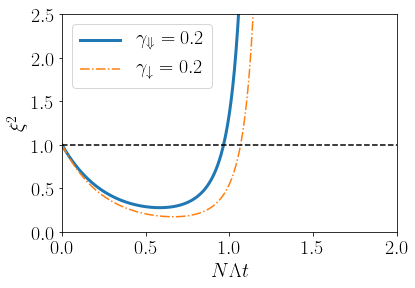

In [63]:
lw = 5
label_size = 20
lw = 3
ls=20
texplot = True
if texplot == True:
    plt.rc('text', usetex = True)
    plt.rc('xtick', labelsize=label_size) 
    plt.rc('ytick', labelsize=label_size)
for xi2_1 in xi2_1_list[-1:]:
    plt.plot(t*(N*Lambda), xi2_1, '-', label = r' $\gamma_\Downarrow=0.2$', linewidth = lw)
for xi2_2 in xi2_2_list[-1:]:
    plt.plot(t*(N*Lambda), xi2_2, '-.', label = r'$\gamma_\downarrow=0.2$')
plt.plot(t*(N*Lambda), 1+0*t, '--k')
plt.xlim([0,2])
plt.ylim([0,2.5])
plt.legend(fontsize=label_size)
plt.xlabel(r'$ N \Lambda t$', fontsize = ls)
plt.ylabel(r'$\xi^2$', fontsize = ls)
plt.xlabel(r'$ N \Lambda t$', fontsize = ls)
plt.ylabel(r'$\xi^2$', fontsize = ls)

savefile = False
if savefile == True:
    fname = 'plots-piqs-pra/spin_squeezing_intro_N_{}.pdf'.format(N)
    plt.savefig(fname, bbox_inches='tight')
plt.show()
plt.close()

#### Visualization

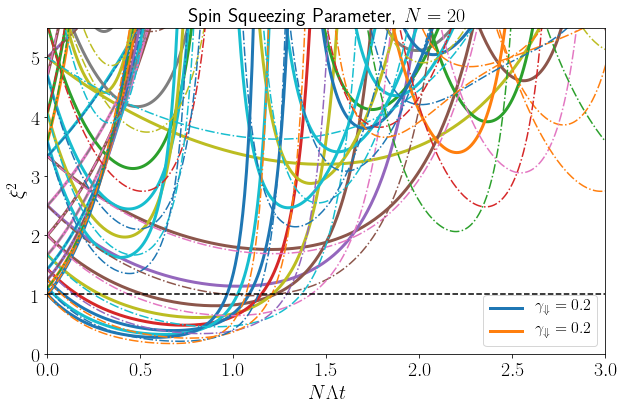

In [64]:
ls = label_size
fig1 = plt.figure(figsize = (10,6))
plt.plot(t*(N*Lambda), xi2_1_list[0], '-', label = r' $\gamma_\Downarrow=0.2$', linewidth = lw)
for xi2_1 in xi2_1_list[1:]:
    plt.plot(t*(N*Lambda), xi2_1, '-', linewidth = lw)
plt.plot(t*(N*Lambda), xi2_2_list[0], '-', label = r' $\gamma_\Downarrow=0.2$', linewidth = lw)
for xi2_2 in xi2_2_list[1:]:
    plt.plot(t*(N*Lambda), xi2_2, '-.')
plt.plot(t*(N*Lambda), 1+0*t, '--k')
plt.xlim([0,3])
plt.ylim([0,5.5])
plt.xlabel(r'$ N \Lambda t$', fontsize = ls)
plt.ylabel(r'$\xi^2$', fontsize = ls)
plt.legend(fontsize = ls*0.8)
savefile = False
if savefile == True:
    fname = 'plots-piqs-pra/spin_squeezing_N_{}.pdf'.format(N)
    plt.savefig(fname, bbox_inches='tight')
plt.title(r'Spin Squeezing Parameter, $N={}$'.format(N), fontsize = ls)
plt.show()
plt.close()

# Trade-off studies

In [65]:
## Here we find for how long the spin-squeezing parameter, xi2, 
## is less than 1 (non-classical or "quantum" condition), in the two dynamics

dt_quantum_xi1_list = []
dt_quantum_xi2_list = []
dt1_jm =[]
dt2_jm =[]

min_quantum_xi1_list = []
min_quantum_xi2_list = []
min_xi1_jm =[]
min_xi2_jm =[]

j_list1=[]
m_list1=[]
j_list2=[]
m_list2=[]
dt_list1=[]
dt_list2=[]
xi_list1=[]
xi_list2=[]

j_list=[]
m_list=[]

ds = dicke_space(N)
dt = t[1]-t[0]
i = 0
for j in j_vals(N):
    for m in m_vals(j):
        #print(j,m)
        j_list.append(j)
        m_list.append(m)
        rho0 = dicke(N, j, m)
        quantum_xi1 = xi2_1_list[i][xi2_1_list[i] < 1.0] 
        quantum_xi2 = xi2_2_list[i][xi2_2_list[i] < 1.0]

        # first ensemble
        if len(quantum_xi1)>0:
            dt_quantum_xi1 = dt*len(quantum_xi1)
            min_xi1 = min(quantum_xi1)
            dt1_jm.append((dt_quantum_xi1, j, m))
            min_xi1_jm.append((min_xi1, j, m))
            j_list1.append(j)
            m_list1.append(m)
            dt_list1.append(dt_quantum_xi1)
            xi_list1.append(min_xi1)
            

        else:
            dt_quantum_xi1 = 0.0

        # second ensemble
        if len(quantum_xi2)>0:
            dt_quantum_xi2 = dt*len(quantum_xi2)
            min_xi2 = min(quantum_xi2)
            dt2_jm.append((dt_quantum_xi2, j, m))
            min_xi2_jm.append((min_xi2, j, m))
            j_list2.append(j)
            m_list2.append(m)
            dt_list2.append(dt_quantum_xi2)
            xi_list2.append(min_xi2)
        else:
            dt_quantum_xi2 = 0.0

        dt_quantum_xi1_list.append(dt_quantum_xi1)
        dt_quantum_xi2_list.append(dt_quantum_xi2)
        min_quantum_xi1_list.append(min_xi1_jm)
        min_quantum_xi2_list.append(min_xi2_jm)        

        i = i+1

/Users/shahnawaz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less
/Users/shahnawaz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


In [66]:
j_list

[0.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0]

In [67]:
# max squeezing time
print("collective emission: (xi_time, j, m)")
print(dt1_jm)
print("local emission: (xi_time, j, m)")
print(dt2_jm)
# max squeezing value (min(xi^2))
print("collective emission: (xi_min, j, m)")
print(min_xi1_jm)
print("local emission: (xi_min, j, m)")
print(min_xi2_jm)

collective emission: (xi_time, j, m)
[(0.035500000000000004, 5.0, 5.0), (0.046, 6.0, 6.0), (0.049, 7.0, 7.0), (0.05, 8.0, 8.0), (0.0495, 9.0, 9.0), (0.048, 10.0, 10.0)]
local emission: (xi_time, j, m)
[(0.0125, 4.0, 4.0), (0.049, 5.0, 5.0), (0.056, 6.0, 6.0), (0.057, 7.0, 7.0), (0.0565, 8.0, 8.0), (0.055, 9.0, 9.0), (0.053, 10.0, 10.0)]
collective emission: (xi_min, j, m)
[(0.8100948844413854, 5.0, 5.0), (0.6116702089009617, 6.0, 6.0), (0.4819040239607016, 7.0, 7.0), (0.39182580440306064, 8.0, 8.0), (0.3264419669720454, 9.0, 9.0), (0.2772936210623191, 10.0, 10.0)]
local emission: (xi_min, j, m)
[(0.9803912829084156, 4.0, 4.0), (0.64330522261139, 5.0, 5.0), (0.45586017017628977, 6.0, 6.0), (0.34056060197682064, 7.0, 7.0), (0.26436913458180517, 8.0, 8.0), (0.2113371817681633, 9.0, 9.0), (0.1729381093918849, 10.0, 10.0)]


## 1) Trade-off Dicke state

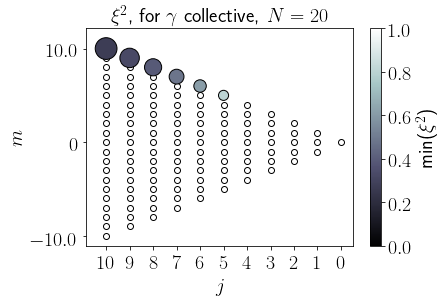

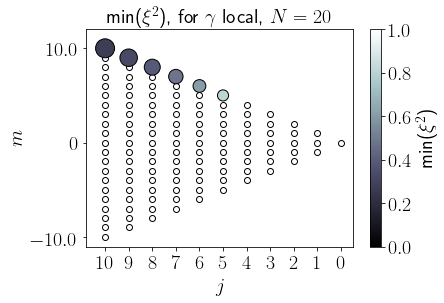

In [68]:
s0=100
s1=s0/4
cm = plt.cm.get_cmap('copper_r')
cm = plt.cm.get_cmap('plasma_r')
cm = plt.cm.get_cmap('Greys_r')
cm = plt.cm.get_cmap('bone')

# first plot
plt.figure()
sc2 = plt.scatter(j_list,m_list,#c=np.array(j_list)*0, 
                  c='w',marker='o',edgecolors='k')

sc = plt.scatter(j_list1, m_list1, c=np.array(xi_list1),
                 s=s0/np.array(xi_list2),
                 vmin=0,vmax=1,cmap=cm,marker='o',edgecolors='k')



xvec = [r"${}$".format(int(j_vals(N)[i])) for i in range(0,len(j_vals(N)))]
#yvec = [r"${}$".format(i) for i in m_vals(N/2)]
#plt.yticks(m_vals(N/2),yvec, fontsize = ls)

yvec = [r"${}$".format(i) for i in [m_vals(N/2)[0],0,m_vals(N/2)[-1]]]
yvec0 = [m_vals(N/2)[0],0,m_vals(N/2)[-1]]
plt.yticks(yvec0,yvec, fontsize = ls)
plt.xticks(j_vals(N), xvec, fontsize = ls)
plt.xlabel(r'$ j$', fontsize = ls)
plt.ylabel(r'$m$', fontsize = ls)
cb = plt.colorbar(sc)
cb.set_label(r"min($\xi^2$)", fontsize = ls)
savefile = False
if savefile == True:
    fname = 'plots-piqs-pra/spin-squeezing-xi-dicke-space-collective-N_{}.pdf'.format(N)
    plt.savefig(fname, bbox_inches='tight')
plt.title(r'$\xi^2$, for $\gamma$ collective, $N={}$'.format(N),
          fontsize = ls)
plt.gca().invert_xaxis()
plt.show()
plt.close()
# second plot
plt.figure()
sc2 = plt.scatter(j_list,m_list,#c=np.array(j_list)*0, 
                  c='w',marker='o',edgecolors='k')
sc = plt.scatter(j_list1, m_list1, c=np.array(xi_list1),
                 s=s0/np.array(xi_list1),
                 vmin=0,vmax=1,cmap=cm,marker='o',edgecolors='k')
plt.yticks(yvec0,yvec, fontsize = ls)
plt.xticks(j_vals(N), xvec, fontsize = ls)
plt.xlabel(r'$ j$', fontsize = ls)
plt.ylabel(r'$m$', fontsize = ls)
plt.gca().invert_xaxis()
cb = plt.colorbar(sc)
cb.set_label(r"min($\xi^2$)", fontsize = ls)
savefile = False
if savefile == True:
    fname = 'plots-piqs-pra/spin-squeezing-xi-dicke-space-local-N_{}.pdf'.format(N)
    plt.savefig(fname, bbox_inches='tight')
plt.title(r'min($\xi^2$), for $\gamma$ local, $N={}$'.format(N), 
          fontsize = ls)

plt.show()
plt.close()

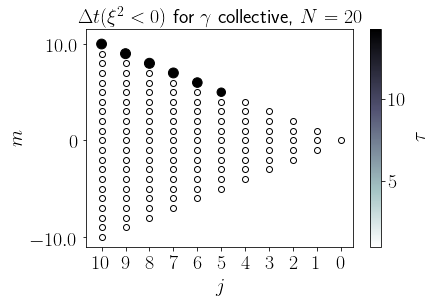

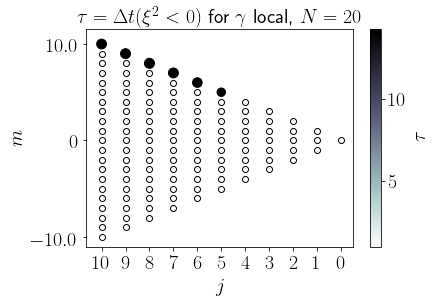

In [69]:
s0=100
s1=s0/4

# first plot
plt.figure()
cm = plt.cm.get_cmap('copper_r')
cm = plt.cm.get_cmap('plasma_r')
#cm = plt.cm.get_cmap('Greys_r')
cm = plt.cm.get_cmap('bone_r')
sc2 = plt.scatter(j_list,m_list,#c=np.array(j_list)*0, 
                  c='w',marker='o',edgecolors='k')
sc = plt.scatter(j_list1, m_list1, 
                 c=np.array(dt_list1)/max(dt_list1)*(N*Lambda),
                 s=s0*np.array(dt_list1)*(N*Lambda),
                 vmin=min(dt_list1)/max(dt_list1)*(N*Lambda),
                 vmax=max(dt_list1)*(N*Lambda),
                 cmap=cm,marker='o',edgecolors='k')

xvec = [r"${}$".format(int(j_vals(N)[i])) for i in range(0,len(j_vals(N)))]
#yvec = [r"${}$".format(i) for i in m_vals(N/2)]
#plt.yticks(m_vals(N/2),yvec, fontsize = ls)

yvec = [r"${}$".format(i) for i in [m_vals(N/2)[0],0,m_vals(N/2)[-1]]]
yvec0 = [m_vals(N/2)[0],0,m_vals(N/2)[-1]]
plt.yticks(yvec0,yvec, fontsize = ls)


plt.xticks(j_vals(N), xvec, fontsize = ls)
plt.xlabel(r'$ j$', fontsize = ls)
plt.ylabel(r'$m$', fontsize = ls)
cb = plt.colorbar(sc)
cb.set_label(r"$\tau$", fontsize = ls)
plt.gca().invert_xaxis()
savefile = True
if savefile == True:
    fname = 'plots-piqs-pra/spin-squeezing-time-dicke-space-collective-N_{}.pdf'.format(N)
    plt.savefig(fname, bbox_inches='tight')
plt.title(r"$\Delta t(\xi^2<0)$ for $\gamma$ collective, $N={}$".format(N), 
          fontsize = ls)
plt.show()
plt.close()

# second plot
plt.figure()
cm = plt.cm.get_cmap('bone_r')
sc2 = plt.scatter(j_list,m_list,#c=np.array(j_list)*0, 
                  c='w',marker='o',edgecolors='k')
sc = plt.scatter(j_list1, m_list1, 
                 c=np.array(dt_list1)/max(dt_list1)*(N*Lambda),
                 s=s0*np.array(dt_list1)*(N*Lambda),
                 vmin=min(dt_list1)/max(dt_list1)*(N*Lambda),
                 vmax=max(dt_list1)*(N*Lambda),
                 cmap=cm,marker='o',edgecolors='k')
plt.yticks(yvec0,yvec, fontsize = ls)
plt.xticks(j_vals(N), xvec, fontsize = ls)
plt.xlabel(r'$ j$', fontsize = ls)
plt.ylabel(r'$m$', fontsize = ls)
plt.gca().invert_xaxis()
cb = plt.colorbar(sc)
cb.set_label(r"$\tau$", fontsize = ls)
#cb.set_label(r"$\Delta t(\xi^2<0)$", fontsize = ls)
savefile = True
if savefile == True:
    fname = 'plots-piqs-pra/spin-squeezing-time-dicke-space-local-N_{}.pdf'.format(N)
    plt.savefig(fname, bbox_inches='tight')
plt.title(r"$\tau=\Delta t(\xi^2<0)$ for $\gamma$ local, $N={}$".format(N), 
          fontsize = ls)
plt.show()
plt.close()

## 2) Trade-off squeezing time vs squeezing depth

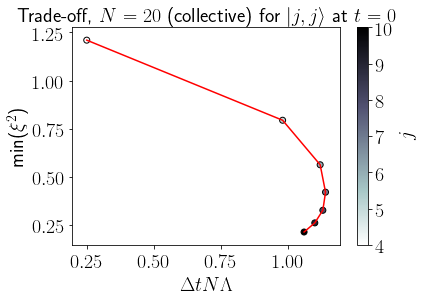

In [99]:
plt.figure()
cm = plt.cm.get_cmap('bone_r')
ax0 = plt.plot(np.array(dt_list2)*(N*Lambda),
                 np.array(xi_list2)/max(xi_list1), '-', color="r")
ax = plt.scatter(np.array(dt_list2)*(N*Lambda),
                 np.array(xi_list2)/max(xi_list1),
                 c=j_list2,
                 vmin=min(j_list2),
                 vmax=N/2,
                 cmap=cm,
                 edgecolors='k')


plt.xlabel(r'$ \Delta t N\Lambda$', fontsize = ls)
plt.ylabel(r'min($\xi^2$)', fontsize = ls)
cb = plt.colorbar(ax, ticks=j_list2)
cb.set_ticks(j_list2)
cb.set_label(r"$j$", fontsize = ls)
savefile = True
if savefile == True:
    fname = 'plots-piqs-pra/spin-squeezing-tradeoff-collective-N_{}.pdf'.format(N)
    plt.savefig(fname, bbox_inches='tight')
plt.title(r'Trade-off, $N={}$ (collective) for $|j,j\rangle$ at $t=0$'.format(N), 
          fontsize = ls)
plt.show()
plt.close()

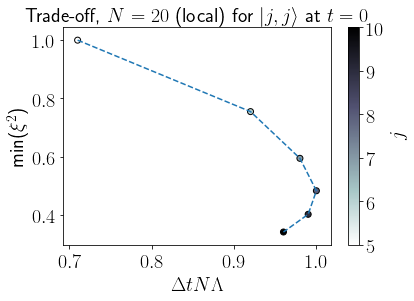

In [94]:
plt.figure()
cm = plt.cm.get_cmap('bone_r')
ax0 = plt.plot(np.array(dt_list1)*(N*Lambda),
                 np.array(xi_list1)/max(xi_list1), '--')
ax = plt.scatter(np.array(dt_list1)*(N*Lambda),
                 np.array(xi_list1)/max(xi_list1),
                 c=j_list1,
                 vmin=min(j_list1),
                 vmax=N/2,
                 cmap=cm,
                 edgecolors='k')
plt.xlabel(r'$ \Delta t N\Lambda$', fontsize = ls)
plt.ylabel(r'min($\xi^2$)', fontsize = ls)
cb = plt.colorbar(ax, ticks=j_list1)
cb.set_ticks(j_list1)
cb.set_label(r"$j$", fontsize = ls)
savefile = True
if savefile == True:
    fname = 'plots-piqs-pra/spin-squeezing-tradeoff-local-N_{}.pdf'.format(N)
    plt.savefig(fname, bbox_inches='tight')
plt.title(r'Trade-off, $N={}$ (local) for $|j,j\rangle$ at $t=0$'.format(N), fontsize = ls)
plt.show()
plt.close()

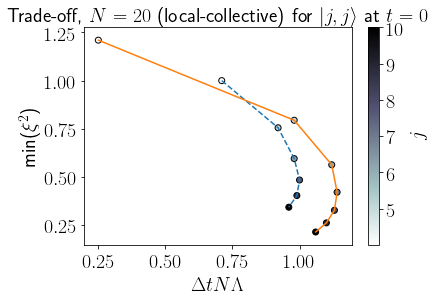

In [95]:
# local and collective
plt.figure()
cm = plt.cm.get_cmap('bone_r')
ax0 = plt.plot(np.array(dt_list1)*(N*Lambda),
                 np.array(xi_list1)/max(xi_list1), '--')
ax = plt.scatter(np.array(dt_list1)*(N*Lambda),
                 np.array(xi_list1)/max(xi_list1),
                 c=j_list1,
                 vmin=min(j_list1),
                 vmax=N/2,
                 cmap=cm,
                 edgecolors='k')
ax0 = plt.plot(np.array(dt_list2)*(N*Lambda),
                 np.array(xi_list2)/max(xi_list1), '-')
ax = plt.scatter(np.array(dt_list2)*(N*Lambda),
                 np.array(xi_list2)/max(xi_list1),
                 c=j_list2,
                 vmin=min(j_list2),
                 vmax=N/2,
                 cmap=cm,
                 edgecolors='k')

plt.xlabel(r'$ \Delta t N\Lambda$', fontsize = ls)
plt.ylabel(r'min($\xi^2$)', fontsize = ls)
cb = plt.colorbar(ax, ticks=j_list2)
cb.set_ticks(j_list1)
cb.set_label(r"$j$", fontsize = ls)
savefile = True
if savefile == True:
    fname = 'plots-piqs-pra/spin-squeezing-tradeoff-local-collective-N_{}.pdf'.format(N)
    plt.savefig(fname, bbox_inches='tight')
plt.title(r'Trade-off, $N={}$ (local-collective) for $|j,j\rangle$ at $t=0$'.format(N), fontsize = ls)
plt.show()
plt.close()



## 3) Trade-off collective vs local incoherent processes

In [71]:
## general parameters
N = 20
nds = num_dicke_states(N)
[jx, jy, jz] = jspin(N)
jp = jspin(N, "+")
jm = jspin(N, "-")
jpjm = jp*jm
excited = dicke(N, N/2, N/2)
rho0 = excited
# Fixed dynamics parameters
Lambda = 1
factor_l = 1
h = -1j*Lambda * (jp**2-jm**2)
nt = 1001
td0 = 1/(N*Lambda)
tmax =  10 * td0
t = np.linspace(0, tmax, nt)
# parameter space 
ng1 = 20
ng2 = 20
gCE_max = Lambda/factor_l
gE_max = Lambda/factor_l*5
gE_list = np.linspace(0,gE_max,ng1)
gCE_list = np.linspace(0,gCE_max,ng2)
xi2_3_min = np.zeros((ng2, ng1))

In [72]:
for i in range(0,len(gE_list)):
    print(i,len(gE_list))
    for j in range(0,len(gCE_list)): 
        system3 = Dicke(N=N)
        system3.emission = gE_list[i]
        system3.collective_emission = gCE_list[j]
        system3.hamiltonian = h
        liouv3 = system3.liouvillian()  
        result = mesolve(liouv3,rho0,t,[], 
                         e_ops=[jz,jy,jy**2,jx])
        jz_t = result.expect[0]
        jy_t = result.expect[1]
        jy2_t = result.expect[2]
        jx_t = result.expect[3]
        Delta_jy = jy2_t - jy_t**2
        xi2_3 = N*Delta_jy/(jz_t**2+jx_t**2)
        xi2_3_min[j,i] = np.min(xi2_3)

0 20
1 20
2 20
3 20
4 20
5 20
6 20
7 20
8 20
9 20
10 20
11 20
12 20
13 20
14 20
15 20
16 20
17 20
18 20
19 20


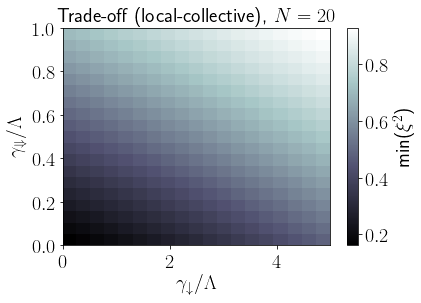

In [73]:
ls = 20
N = 20
plt.rc('text', usetex = True)
plt.rc('xtick', labelsize=ls) 
plt.rc('ytick', labelsize=ls)
plt.figure()
cm = plt.cm.get_cmap('bone')
cf = plt.pcolormesh(gE_list,gCE_list,
                  xi2_3_min, 
                  #vmin=np.min(xi2_3_min),vmax=np.max(xi2_3_min),
                  cmap=cm)
cb = plt.colorbar(cf)
plt.xlabel(r"$\gamma_\downarrow/\Lambda$", fontsize = ls)
plt.ylabel(r"$\gamma_\Downarrow/\Lambda$", fontsize = ls)
#cb.set_ticks([np.min(xi2_3_min),np.max(xi2_3_min)])
#cb.set_ticks([0,1])
cb.set_label(r"min($\xi^2$)", fontsize = ls)
savefile = True
if savefile == True:
    fname = 'plots-piqs-pra/d-spin-squeezing-parameters-N_{}.pdf'.format(N)
    plt.savefig(fname, bbox_inches='tight')
plt.title(r'Trade-off (local-collective), $N={}$'.format(N),
          fontsize = ls)
plt.show()
plt.close()

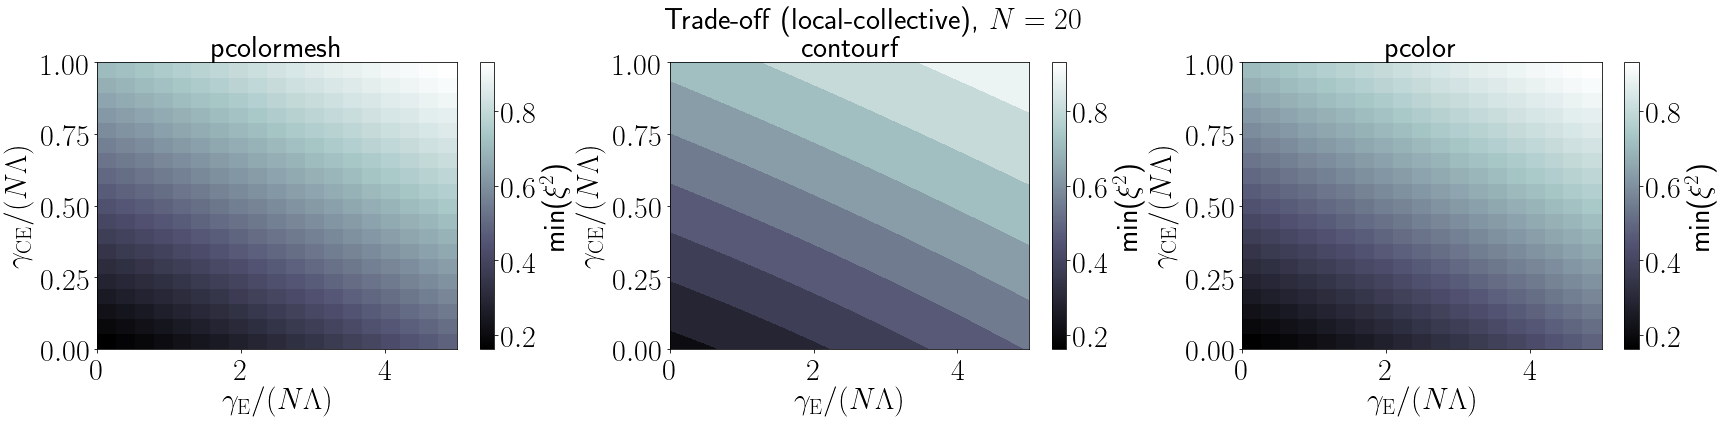

In [74]:
ls = 30
plt.rc('text', usetex = True)
plt.rc('xtick', labelsize=ls) 
plt.rc('ytick', labelsize=ls)
fig, axes = plt.subplots(1, 3, figsize=(8*3, 6))
fig.suptitle(r'Trade-off (local-collective), $N={}$'.format(N),
          fontsize = ls)
cm = plt.get_cmap('bone')
#1
cf = axes[0].pcolormesh(gE_list,gCE_list,xi2_3_min, cmap=cm)
cb = fig.colorbar(cf,ax=axes[0])
axes[0].set_xlabel(r"$\gamma_\mathrm{E}/(N\Lambda)$", fontsize = ls)
axes[0].set_ylabel(r"$\gamma_\mathrm{CE}/(N\Lambda)$", fontsize = ls)
cb.set_label(r"min($\xi^2$)", fontsize = ls)
axes[0].set_title('pcolormesh'.format(N),fontsize = ls)
#2
cf2 = axes[1].contourf(gE_list,gCE_list,xi2_3_min,cmap=cm)
cb2 = fig.colorbar(cf,ax=axes[1])
axes[1].set_xlabel(r"$\gamma_\mathrm{E}/(N\Lambda)$", fontsize = ls)
axes[1].set_ylabel(r"$\gamma_\mathrm{CE}/(N\Lambda)$", fontsize = ls)
cb2.set_label(r"min($\xi^2$)", fontsize = ls)
axes[1].set_title('contourf'.format(N),fontsize = ls)
#3
cm = plt.cm.get_cmap('bone')
cf3 = plt.pcolor(gE_list,gCE_list,xi2_3_min,cmap=cm)
cb3 = plt.colorbar(cf,ax=axes[2])
axes[2].set_xlabel(r"$\gamma_\mathrm{E}/(N\Lambda)$", fontsize = ls)
axes[2].set_ylabel(r"$\gamma_\mathrm{CE}/(N\Lambda)$", fontsize = ls)
cb3.set_label(r"min($\xi^2$)", fontsize = ls)
axes[2].set_title(r'pcolor'.format(N),fontsize = ls)
plt.suptitle(r'Trade-off (local-collective), $N={}$'.format(N),
          fontsize = ls)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()
plt.close()


## 4) Trade-off incoherent processes vs $N$, the TLS number

In [75]:
## general parameters
N0 = 1
Nmax = 30
N_list = np.linspace(N0,Nmax,Nmax+1-N0)
print(N_list)
nt = 1001
td0 = 1/(Nmax*Lambda)
tmax =  5 * td0
t = np.linspace(0, tmax, nt)
# parameter space 
Lambda = 1
gCE = 0.2*Lambda # value of gCE/Lambda is fixed
ngE = 30
gEgCE_list = np.linspace(0, Nmax, ngE)# value of gE/gCE,
xplot = len(gEgCE_list)
yplot = len(N_list)
xi2_4_min = np.zeros((xplot, yplot))
(gEgCE_list)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]


array([ 0.        ,  1.03448276,  2.06896552,  3.10344828,  4.13793103,
        5.17241379,  6.20689655,  7.24137931,  8.27586207,  9.31034483,
       10.34482759, 11.37931034, 12.4137931 , 13.44827586, 14.48275862,
       15.51724138, 16.55172414, 17.5862069 , 18.62068966, 19.65517241,
       20.68965517, 21.72413793, 22.75862069, 23.79310345, 24.82758621,
       25.86206897, 26.89655172, 27.93103448, 28.96551724, 30.        ])

In [76]:
xi2_4_list = []
t_min_xi2_list = []
min_xi2_list = []
for i in range(0,len(N_list)):
    n = int(N_list[i])
    print(n)
    nds = num_dicke_states(n)
    [jx, jy, jz] = jspin(n)
    jp = jspin(n, "+")
    jm = jspin(n, "-")
    jpjm = jp*jm
    excited = dicke(n, n/2, n/2)
    rho0 = excited
    # dynamics parameters
    h = -1j*Lambda * (jp**2-jm**2)
    for j in range(0,len(gEgCE_list)): 
        system4 = Dicke(N=n)
        system4.emission = gCE*gEgCE_list[j]
        system4.collective_emission = gCE
        system4.hamiltonian = h
        liouv4 = system4.liouvillian()  
        result = mesolve(liouv4,rho0,t,[], 
                         e_ops=[jz,jy,jy**2,jx])
        jz_t = result.expect[0]
        jy_t = result.expect[1]
        jy2_t = result.expect[2]
        jx_t = result.expect[3]
        Delta_jy = jy2_t - jy_t**2
        xi2_4 = n*Delta_jy/(jz_t**2+jx_t**2)
        xi2_4_min[j,i] = np.min(xi2_4)
        xi2_4_list.append(xi2_4)
        it_min = np.argmin(xi2_4)
        t_min_xi2_list.append(t[it_min])
        min_xi2_list.append(np.min(xi2_4))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [77]:
k=0
tmin_mat = np.zeros((xplot, yplot))
for i in range(0,len(N_list)):
    for j in range(0,len(gEgCE_list)): 
        tmin_mat[j,i] = t_min_xi2_list[k]
        k=k+1
        

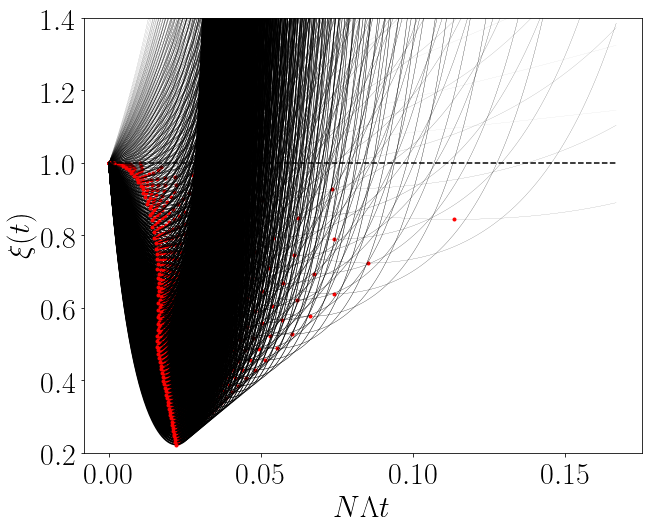

In [78]:
# check the spin squeezing parameter evolution
plt.figure(figsize=(10,8))
for i in range(0,len(xi2_4_list)):
    plt.plot(t, xi2_4_list[i],'k-',linewidth=0.03+i/500)
    plt.plot(t_min_xi2_list[i], min_xi2_list[i],'r.')



plt.plot(t, 1+t*0,'k--')
plt.ylim([0.2,1.4])
#plt.xlim([0,0.2])
plt.ylabel(r"$\xi(t)$", fontsize = ls)
plt.xlabel(r"$N\Lambda t$", fontsize = ls)
plt.show()
plt.close()


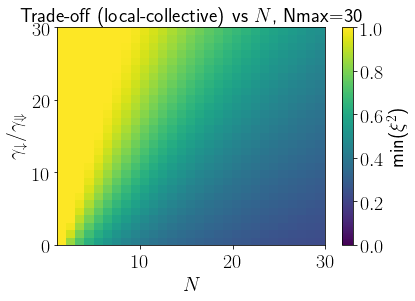

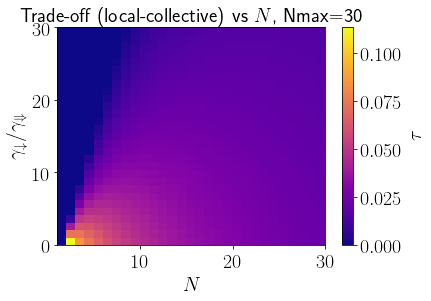

In [79]:
# parameter trade-off study
ls = 20
N=30
plt.rc('text', usetex = True)
plt.rc('xtick', labelsize=ls) 
plt.rc('ytick', labelsize=ls)
plt.figure()
cm = plt.cm.get_cmap('plasma')
cf = plt.pcolor(N_list,gEgCE_list,
                  xi2_4_min, 
                  vmin=0.,vmax=1)#,
                  #vmin=np.min(xi2_4_min),vmax=np.max(xi2_4_min),
                  #cmap=cm)
cb = plt.colorbar(cf)
plt.ylabel(r"$\gamma_\downarrow/\gamma_\Downarrow$", fontsize = ls)
plt.xlabel(r"$N$", fontsize = ls)
#cb.set_ticks([np.min(xi2_4_min),np.max(xi2_4_min)])
#cb.set_ticks([0,1])
cb.set_label(r"min($\xi^2$)", fontsize = ls)
savefile = True
if savefile == True:
    fname = 'plots-piqs-pra/spin-squeezing-xi-Nscaling-N_{}.pdf'.format(N)
    plt.savefig(fname, bbox_inches='tight')
plt.title(r'Trade-off (local-collective) vs $N$, Nmax={}'.format(Nmax),
          fontsize = ls)
plt.show()
plt.close()


# parameter trade-off study 2 Time
ls = 20
plt.rc('text', usetex = True)
plt.rc('xtick', labelsize=ls) 
plt.rc('ytick', labelsize=ls)
plt.figure()
cm = plt.cm.get_cmap('plasma')
cf = plt.pcolor(N_list,gEgCE_list,
                  tmin_mat*(Lambda), 
                  #vmin=0.,vmax=1,
                  #vmin=np.min(xi2_4_min),vmax=np.max(xi2_4_min),
                  cmap=cm)
cb = plt.colorbar(cf)
plt.ylabel(r"$\gamma_\downarrow/\gamma_\Downarrow$", fontsize = ls)
plt.xlabel(r"$N$", fontsize = ls)
#cb.set_ticks([np.min(xi2_4_min),np.max(xi2_4_min)])
#cb.set_ticks([0,1])
cb.set_label(r"$\tau$", fontsize = ls)
savefile = True
if savefile == True:
    fname = 'plots-piqs-pra/spin-squeezing-tau-Nscaling-N_{}.pdf'.format(N)
    plt.savefig(fname, bbox_inches='tight')
plt.title(r'Trade-off (local-collective) vs $N$, Nmax={}'.format(Nmax),
          fontsize = ls)
plt.show()
plt.close()

In [80]:
## general parameters
N0 = 1
Nmax = 30
N_list = np.linspace(N0,Nmax,Nmax+1-N0)
print(N_list)
nt = 1001
td0 = 1/(Nmax*Lambda)
tmax =  5 * td0
t = np.linspace(0, tmax, nt)
# parameter space 
Lambda = 1
gCE = 0.2*Lambda # value of gCE/Lambda is fixed
ngE = 30
gEgCE_list = np.linspace(0, Nmax*gCE, ngE)# value of gE/gCE,
xplot = len(gEgCE_list)
yplot = len(N_list)
xi2_4_min = np.zeros((xplot, yplot))
(gEgCE_list)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]


array([0.        , 0.20689655, 0.4137931 , 0.62068966, 0.82758621,
       1.03448276, 1.24137931, 1.44827586, 1.65517241, 1.86206897,
       2.06896552, 2.27586207, 2.48275862, 2.68965517, 2.89655172,
       3.10344828, 3.31034483, 3.51724138, 3.72413793, 3.93103448,
       4.13793103, 4.34482759, 4.55172414, 4.75862069, 4.96551724,
       5.17241379, 5.37931034, 5.5862069 , 5.79310345, 6.        ])

In [81]:
xi2_4_list = []
t_min_xi2_list = []
min_xi2_list = []
for i in range(0,len(N_list)):
    n = int(N_list[i])
    print(n)
    nds = num_dicke_states(n)
    [jx, jy, jz] = jspin(n)
    jp = jspin(n, "+")
    jm = jspin(n, "-")
    jpjm = jp*jm
    excited = dicke(n, n/2, n/2)
    rho0 = excited
    # dynamics parameters
    h = -1j*Lambda * (jp**2-jm**2)
    for j in range(0,len(gEgCE_list)): 
        system4 = Dicke(N=n)
        system4.emission = gEgCE_list[j]
        system4.collective_emission = gCE
        system4.hamiltonian = h
        liouv4 = system4.liouvillian()  
        result = mesolve(liouv4,rho0,t,[], 
                         e_ops=[jz,jy,jy**2,jx])
        jz_t = result.expect[0]
        jy_t = result.expect[1]
        jy2_t = result.expect[2]
        jx_t = result.expect[3]
        Delta_jy = jy2_t - jy_t**2
        xi2_4 = n*Delta_jy/(jz_t**2+jx_t**2)
        xi2_4_min[j,i] = np.min(xi2_4)
        xi2_4_list.append(xi2_4)
        it_min = np.argmin(xi2_4)
        t_min_xi2_list.append(t[it_min])
        min_xi2_list.append(np.min(xi2_4))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


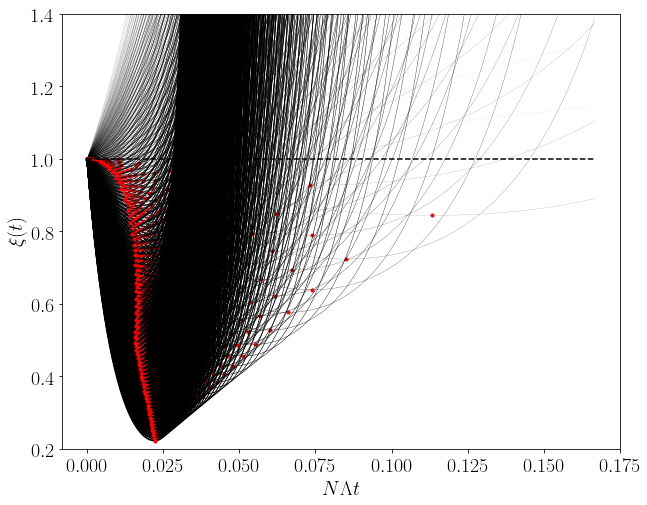

In [82]:
# check the spin squeezing parameter evolution
plt.figure(figsize=(10,8))
for i in range(0, len(xi2_4_list)):
    plt.plot(t, xi2_4_list[i],'k-',linewidth=0.03+i/500)
    plt.plot(t_min_xi2_list[i], min_xi2_list[i],'r.')
plt.plot(t, 1+t*0,'k--')
plt.ylim([0.2,1.4])
#plt.xlim([0,0.2])
plt.ylabel(r"$\xi(t)$", fontsize = ls)
plt.xlabel(r"$N\Lambda t$", fontsize = ls)
plt.show()
plt.close()

Text(0.5, 0, '$N$')

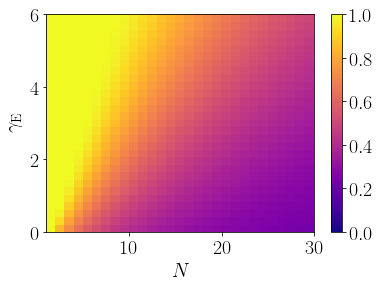

In [83]:
# parameter trade-off study
ls = 20
plt.rc('text', usetex = True)
plt.rc('xtick', labelsize=ls) 
plt.rc('ytick', labelsize=ls)
plt.figure()
cm = plt.cm.get_cmap('plasma')
cf = plt.pcolor(N_list,gEgCE_list,
                  xi2_4_min, 
                  vmin=0.,vmax=1,
#                   vmin=np.min(xi2_4_min),vmax=np.max(xi2_4_min),
                  cmap=cm)
cb = plt.colorbar(cf)
plt.ylabel(r"$\gamma_\mathrm{E}$", fontsize = ls)
plt.xlabel(r"$N$", fontsize = ls)

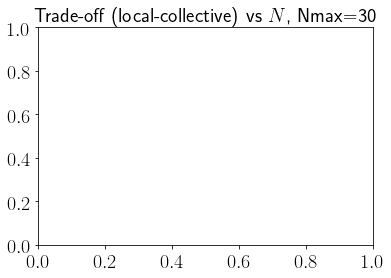

In [84]:
#cb.set_ticks([np.min(xi2_4_min),np.max(xi2_4_min)])
#cb.set_ticks([0,1])
cb.set_label(r"min($\xi^2$)", fontsize = ls)
savefile = True
if savefile == True:
    fname = 'plots-piqs-pra/spin-squeezing-Nscaling-gE-N_{}.pdf'.format(N)
    plt.savefig(fname, bbox_inches='tight')
plt.title(r'Trade-off (local-collective) vs $N$, Nmax={}'.format(Nmax),
          fontsize = ls)
plt.show()
plt.close()


## Previous study: Alternative Visualization in the Dicke space

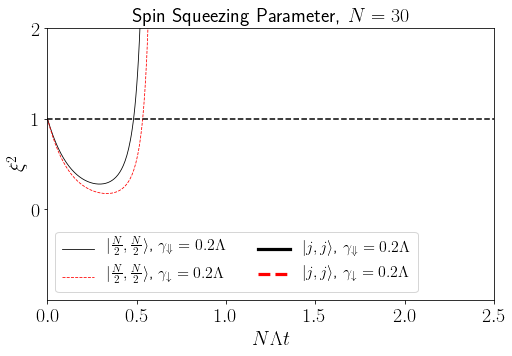

In [85]:
plt.rc('text', usetex = True)
label_size = 20
ls = 20
label_size3 = 20
plt.rc('xtick', labelsize=label_size) 
plt.rc('ytick', labelsize=label_size)

lw = 3
i0 = -14
i0s=2
fig1 = plt.figure(figsize = (8,5))
# excited state spin squeezing
plt.plot(t*(N*Lambda), xi2_1_list[-1], 'k-', 
         label = r'$|\frac{N}{2},\frac{N}{2}\rangle$, $\gamma_\Downarrow=0.2\Lambda$', 
         linewidth = 0.8)
plt.plot(t*(N*Lambda), xi2_2_list[-1], 'r--',
         label = r'$|\frac{N}{2},\frac{N}{2}\rangle$, $\gamma_\downarrow=0.2\Lambda$',
         linewidth = 0.8)
# state with max time of spin squeezing

plt.plot(t*(N*Lambda), xi2_1_list[i0], 'k-', 
         label = r'$|j,j\rangle$, $\gamma_\Downarrow=0.2\Lambda$', 
         linewidth = 0.8+0.4*i0s*lw)
plt.plot(t*(N*Lambda), xi2_2_list[i0], 'r--',
         label = r'$|j,j\rangle$, $\gamma_\downarrow=0.2\Lambda$',
         linewidth = 0.8+0.4*i0s*lw)
plt.plot(t*(N*Lambda), 1+0*t, '--k')

plt.xlim([0,2.5])
plt.yticks([0,1,2])
plt.ylim([-1,2.])

plt.xlabel(r'$ N \Lambda t$', fontsize = label_size3)
plt.ylabel(r'$\xi^2$', fontsize = label_size3)
plt.legend(fontsize = ls*0.8, ncol=2)
fname = 'spin_squeezing_N_{}_states.pdf'.format(N)
savefigure = False
if savefigure == True:
    plt.savefig(fname, bbox_inches='tight')
plt.title(r'Spin Squeezing Parameter, $N={}$'.format(N), fontsize = ls)
plt.show()
plt.close()

In [87]:
# general parameters
N = 20
nds = num_dicke_states(N)
[jx, jy, jz] = jspin(N)
jp, jm = jspin(N, "+"), jspin(N, "-")
jpjm = jp*jm

Lambda = 1
factor_l = 10

# spin hamiltonian
h = -1j*Lambda * (jp**2-jm**2)

factor = 10
gamma = Lambda/factor_l


# Ensemble with collective emission only
ensemble_ce = Dicke(N=N, hamiltonian=h, collective_emission=gamma)

# Ensemble with local emission only
ensemble_le = Dicke(N=N, hamiltonian=h, emission=gamma)

# Build the Liouvillians for both ensembles
liouv_collective = ensemble_ce.liouvillian() 
liouv_local = ensemble_le.liouvillian()

In [88]:
t = np.linspace(0, 2.5, 1000)
rho0 = dicke(N, 10, 10)

In [89]:
result_collective = mesolve(liouv_collective, rho0, t, [], 
                 e_ops = [jz, jy, jy**2,jz**2, jx])
result_local = mesolve(liouv_local, rho0, t, [], 
                 e_ops = [jz, jy, jy**2,jz**2, jx])

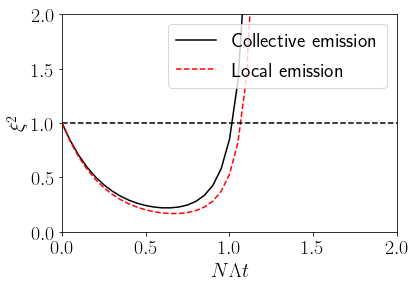

In [90]:
# Get the expectation values
jzt_c, jyt_c, jy2t_c, jz2t_c, jxt_c = result_collective.expect
jzt_l, jyt_l, jy2t_l, jz2t_l, jxt_l = result_local.expect

del_jy_c = jy2t_c - jyt_c**2
del_jy_l = jy2t_l - jyt_l**2

xi2_c = N * del_jy_c/(jzt_c**2 + jxt_c**2)
xi2_l = N * del_jy_l/(jzt_l**2 + jxt_l**2)

plt.plot(t*N, xi2_c, 'k-', label=r"Collective emission")
plt.plot(t*N, xi2_l, 'r--', label=r"Local emission")
plt.plot(t*N, 1+0*t, '--k')
plt.ylabel(r'$\xi^2$', fontsize = label_size3)
plt.xlabel(r'$ N \Lambda t$', fontsize = label_size3)
plt.legend(fontsize = label_size3)

plt.xlim([0, 2])
plt.ylim([0, 2])
plt.show()

#### References

[1] D. J. Wineland, J. J. Bollinger, W. M. Itano, F. L. Moore, and D. J. Heinzen, Spin squeezing and reduced quantum noise in spectroscopy, *Phys. Rev. A* **46**, R6797 (1992)

[2] M. Kitagawa and M. Ueda, Squeezed spin states, *Phys. Rev. A* **47**, 5138 (1993)

[3] J. Ma, X. Wang, C.-P. Sun, and F. Nori, Quantum spin squeezing, *Physics Reports* **509**, 89 (2011)

[4] L. Pezzè, A. Smerzi, M. K. Oberthaler, R. Schmied, and P. Treutlein, Quantum metrology with nonclassical states of atomic ensembles, *Reviews of Modern Physics*, in press (2018)

[5] B. A. Chase and J. Geremia, Collective processes of an ensemble of spin-1 particles, *Phys. Rev. A* **78**,0521012 (2008)

[6] B. Q. Baragiola, B. A. Chase, and J. Geremia, Collective uncertainty in partially polarized and partially deco- hered spin-1 systems, *Phys. Rev. A* **81**, 032104 (2010)

[7] N. Shammah, S. Ahmed, N. Lambert, S. De Liberato, and F. Nori, Open quantum systems with local and collective incoherent processes: Efficient numerical simulation using permutational invariance, **Phys. Rev. A 98, 063815 (2018)** https://arxiv.org/abs/1805.05129 and https://github.com/nathanshammah/piqs/

In [91]:
qutip.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) 2011 and later.
A. J. Pitchford, P. D. Nation, R. J. Johansson, A. Grimsmo, and C. Granade

QuTiP Version:      4.3.1
Numpy Version:      1.15.4
Scipy Version:      1.1.0
Cython Version:     0.28.5
Matplotlib Version: 3.0.0
Python Version:     3.6.6
Number of CPUs:     6
BLAS Info:          INTEL MKL
OPENMP Installed:   False
INTEL MKL Ext:      True
Platform Info:      Darwin (x86_64)
Installation path:  /Users/shahnawaz/anaconda3/lib/python3.6/site-packages/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex file can be easily generated using `qutip.cite()`


In [92]:
qutip.cite()

@article{qutip2,
doi = {10.1016/j.cpc.2012.11.019},
url = {https://doi.org/10.1016/j.cpc.2012.11.019},
year  = {2013},
month = {apr},
publisher = {Elsevier {BV}},
volume = {184},
number = {4},
pages = {1234--1240},
author = {J.R. Johansson and P.D. Nation and Franco Nori},
title = {{QuTiP} 2: A Python framework for the dynamics of open quantum systems},
journal = {Computer Physics Communications}
}
@article{qutip1,
doi = {10.1016/j.cpc.2012.02.021},
url = {https://doi.org/10.1016/j.cpc.2012.02.021},
year  = {2012},
month = {aug},
publisher = {Elsevier {BV}},
volume = {183},
number = {8},
pages = {1760--1772},
author = {J.R. Johansson and P.D. Nation and Franco Nori},
title = {{QuTiP}: An open-source Python framework for the dynamics of open quantum systems},
journal = {Computer Physics Communications}
}
